# Ceci est un notebook qui parle du traitement et de l'analyse de données collectées

<span style="color:green">DROH Ballet Romaric</span> , *ISE Eco*


* import des bibliothèque nécessaire

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import scipy.stats as stats
import plotly.graph_objects as go

from scipy.stats import chi2_contingency
import numpy as np
from sklearn.linear_model import LinearRegression
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import statsmodels.api as sm
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
stop_words = set(stopwords.words('french'))
nltk.download('punkt')
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", ".*do not.*",)

C:\Users\DELL\AppData\Local\Temp\ipykernel_17268\972945396.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# THEME 1: Indicateur économique de la Côte d'Ivoire
<span style="color:white"> Nous allons nettoyer et faire quelques regressions possible avec les données portant sur les indicateurs économique de la Côte d'Ivoire</span


*Creation du dictionnaire et fusion des données*

In [2]:

# Chemin du dossier contenant les fichiers CSV
chemin_dossier = "Scripts/données/"

noms_fichiers = [
    "pib_courant.csv", "pib_hbt.csv", "iphc.csv",
    "va_agri.csv", "va_indus.csv", "va_serv.csv"
]


dataframes = {}

for nom_fichier in noms_fichiers:
    indicateur = nom_fichier.split('.')[0]  
    chemin_complet = chemin_dossier + nom_fichier
    
    try:
        df = pd.read_csv(chemin_complet, encoding='ISO-8859-1')
       
        df.columns = df.columns.str.strip().str.lower()
        
        # Renommer la colonne mal encodée si nécessaire
        if 'annã©e' in df.columns:
            df.rename(columns={'annã©e': 'année'}, inplace=True)
        
        # Afficher les colonnes pour vérifier
        print(f"Colonnes corrigées dans {nom_fichier} : {df.columns}")
        
        # Ajouter le DataFrame au dictionnaire
        dataframes[indicateur] = df
        
    except FileNotFoundError:
        print(f"Erreur : le fichier {chemin_complet} est introuvable.")
        continue

# Étape 2 : Fusionner les données sur la colonne 'année'
try:
    # Démarrer avec le DataFrame 'pib_courant'
    merged_data = dataframes['pib_courant'].copy()
    
    # Fusionner les autres DataFrames
    for indicateur, df in dataframes.items():
        if indicateur != 'pib_courant':
            merged_data = pd.merge(merged_data, df, on='année', how='outer')  # Fusion externe (outer join)
  
    print("Données fusionnées :")
    print(merged_data.head())
    
    merged_data.to_csv('donnees_fusionnees.csv', index=False, encoding='utf-8')
    print("Données fusionnées enregistrées dans 'donnees_fusionnees.csv'.")

except KeyError as e:
    print(f"Erreur : la colonne {e} est absente dans l'un des fichiers.")




Colonnes corrigées dans pib_courant.csv : Index(['année', 'pib_courant'], dtype='object')
Colonnes corrigées dans pib_hbt.csv : Index(['année', 'pib_hbt'], dtype='object')
Colonnes corrigées dans iphc.csv : Index(['année', 'iphc'], dtype='object')
Colonnes corrigées dans va_agri.csv : Index(['année', 'va_agri'], dtype='object')
Colonnes corrigées dans va_indus.csv : Index(['année', 'va_indus'], dtype='object')
Colonnes corrigées dans va_serv.csv : Index(['année', 'va_serv'], dtype='object')
Données fusionnées :
   année    pib_courant pib_hbt   iphc va_agri va_indus va_serv
0   1960  5 492 745 890   1 481  5,559  47,908   13,139  38,953
1   1961  6 038 315 905   1 569  6,205  46,407   13,879  39,714
2   1962  6 112 405 708   1 529  6,121  45,904   13,982  40,114
3   1963  6 998 115 047   1 684  6,179  44,167   14,700  41,133
4   1964  8 230 699 197   1 905  6,217  39,801   16,064  44,135
Données fusionnées enregistrées dans 'donnees_fusionnees.csv'.


*voir les entêtes*

In [3]:
import pandas as pd 
base_bf = pd.read_csv('donnees_fusionnees.csv', encoding='ISO-8859-1')

print(base_bf.head())


   annÃ©e    pib_courant pib_hbt   iphc va_agri va_indus va_serv
0    1960  5 492 745 890   1 481  5,559  47,908   13,139  38,953
1    1961  6 038 315 905   1 569  6,205  46,407   13,879  39,714
2    1962  6 112 405 708   1 529  6,121  45,904   13,982  40,114
3    1963  6 998 115 047   1 684  6,179  44,167   14,700  41,133
4    1964  8 230 699 197   1 905  6,217  39,801   16,064  44,135


*après l'analyse des entêtes, nous allons supprimer les espaces dans la colonne pib_courant et pib_hbt*

In [4]:

nom_fichier = 'donnees_fusionnees.csv'

df = pd.read_csv(nom_fichier, encoding='ISO-8859-1')

def supprimer_espaces(df, colonne):
    if colonne in df.columns:
        df[colonne] = df[colonne].astype(str).str.replace(' ', '', regex=False)
        print(f"Espaces supprimés dans la colonne '{colonne}'.")
    else:
        print(f"Erreur : la colonne '{colonne}' n'existe pas dans le fichier.")

# Supprimer les espaces pour les colonnes 'pib_courant' et 'pib_hbt'
supprimer_espaces(df, 'pib_courant')
supprimer_espaces(df, 'pib_hbt')

# Sauvegarder les modifications
df.to_csv(nom_fichier, index=False, encoding='utf-8')
print("Fichier mis à jour avec succès.")


Espaces supprimés dans la colonne 'pib_courant'.
Espaces supprimés dans la colonne 'pib_hbt'.
Fichier mis à jour avec succès.


*voir le type des differentes colonnes*

In [5]:

# Charger le fichier CSV
df = pd.read_csv('donnees_fusionnees.csv', encoding='ISO-8859-1')
print(df.dtypes)


annÃÂ©e        int64
pib_courant     int64
pib_hbt         int64
iphc           object
va_agri        object
va_indus       object
va_serv        object
dtype: object


*Après avoir vu le type des differentes colonnes, l'on constate que seulement deux sont de type entier.Nous allons convertir les autres colonnes en entier, précisement de type float*

In [6]:

def nettoyer_et_convertir_en_float(dataframe, colonnes):
    for colonne in colonnes:
        try:
            dataframe.columns = dataframe.columns.str.strip()

            dataframe[colonne] = pd.to_numeric(dataframe[colonne].str.replace(',', '').str.strip(), errors='coerce')
        except Exception as e:
            print(f"Erreur lors de la conversion de la colonne {colonne}: {e}")

df = pd.read_csv('donnees_fusionnees.csv', encoding='ISO-8859-1')

df_copy = df.copy()

colonnes_a_nettoyer_et_convertir = [ 'iphc', 'va_agri', 'va_indus', 'va_serv']

nettoyer_et_convertir_en_float(df_copy, colonnes_a_nettoyer_et_convertir)

# Enregistrez le DataFrame modifié
df_copy.to_csv('base_final1_civ.csv', index=False)


*maintenant nous allons voir quelques statistiques sur nos données* , *la base retenue après traitement est la base base_final1_civ*

In [7]:
df = pd.read_csv('base_final1_civ.csv', encoding='ISO-8859-1')
print(df[['pib_courant','pib_hbt', 'iphc', 'va_agri', 'va_indus', 'va_serv']].describe())


        pib_courant      pib_hbt           iphc       va_agri      va_indus  \
count  6.400000e+01    64.000000      64.000000     64.000000     64.000000   
mean   2.712458e+10  2010.921875   55608.078125  24945.921875  18378.593750   
std    1.545626e+10   391.951742   41093.809212   9111.777222   3198.529274   
min    5.492746e+09  1481.000000    5559.000000  14372.000000  13139.000000   
25%    1.896312e+10  1696.750000   12812.250000  16489.000000  15964.500000   
50%    2.291999e+10  1913.000000   43476.500000  24372.500000  17951.000000   
75%    3.068920e+10  2284.250000   93438.750000  31254.250000  20781.250000   
max    7.199363e+10  3017.000000  130765.000000  47908.000000  26267.000000   

            va_serv  
count     64.000000  
mean   46598.468750  
std     8115.437523  
min    34013.000000  
25%    38801.500000  
50%    47249.500000  
75%    54407.750000  
max    60577.000000  


**ANALYSE EXPLORATOIRE DES DONNEES**

*Nous avons visualiser les tandances de nos differents indicateurs de 1960 à 2022*, avant cela, l'encodage nous pose un problème, on affiche le nom des colonnes pour voir le nom reel avant de renommer notamment de l'année

In [8]:
print(df.columns)

Index(['annÃÂÃÂ©e', 'pib_courant', 'pib_hbt', 'iphc', 'va_agri', 'va_indus',
       'va_serv'],
      dtype='object')


In [9]:

df = pd.read_csv('base_final1_civ.csv', encoding='ISO-8859-1')

# Nettoyage des colonnes
df.columns = df.columns.str.strip()  # Enlever les espaces autour des noms de colonnes
df = df.rename(columns={'annÃÂÃÂ©e': 'Annee'})  # Renommer la colonne correctement

# Liste des variables et leurs noms lisibles
variables = {
    'pib_courant': 'PIB courant',
    'pib_hbt': 'PIB par habitant',
    'iphc': 'Indice des prix à la consommation',
    'va_agri': 'Valeur ajoutée - Agriculture',
    'va_indus': 'Valeur ajoutée - Industrie',
    'va_serv': 'Valeur ajoutée - Services'
}

# Créer un graphique interactif
fig = go.Figure()

# Ajouter une trace pour chaque variable
for var, label in variables.items():
    fig.add_trace(go.Scatter(x=df['Annee'], y=df[var], mode='lines+markers', name=label, visible=False))

# Rendre visible la première variable par défaut
fig.data[0].visible = True

# Ajouter un menu déroulant pour choisir la variable à afficher
buttons = []
for i, (var, label) in enumerate(variables.items()):
    buttons.append(
        dict(
            label=label,
            method="update",
            args=[
                {"visible": [j == i for j in range(len(variables))]},  # Activer uniquement la trace sélectionnée
                {"title": f"Evolution de '{label}' de la Côte d'Ivoire de 1960 à 2023"}  
            ]
        )
    )

fig.update_layout(
    title=f"Evolution de '{list(variables.values())[0]}' de la Côte d'Ivoire de 1960 à 2023",  # Titre initial
    xaxis_title="Année",
    yaxis_title="Valeur",
    updatemenus=[dict(
        buttons=buttons,
        direction="down",
        showactive=True,
        active=0,
        x=0.17,
        xanchor="left",
        y=1.15,
        yanchor="top"
    )]
)

# Afficher le graphique interactif
fig.show()


De 1960 à 2023, l'économie de la Côte d'Ivoire a connu une croissance marquée, avec un PIB courant passant de 5,5 milliards à 72 milliards USD. Le PIB par habitant a progressé de 1 481 USD à 2 493 USD, malgré des fluctuations dues à des crises économiques, notamment dans les années 1980-1990. L'indice des prix à la consommation a également connu une augmentation régulière, avec une hausse notable en 1994 suite à la dévaluation du franc CFA. En termes de structure économique, l'agriculture, autrefois dominante, a vu son poids relatif diminuer au profit des services, qui sont devenus le principal moteur de l'économie. L'industrie reste stable mais peine à croître. Depuis 2010, l'économie affiche une reprise dynamique, bien que des défis liés à la diversification industrielle et à la résilience macroéconomique persistent.

**Matrice de correlation**

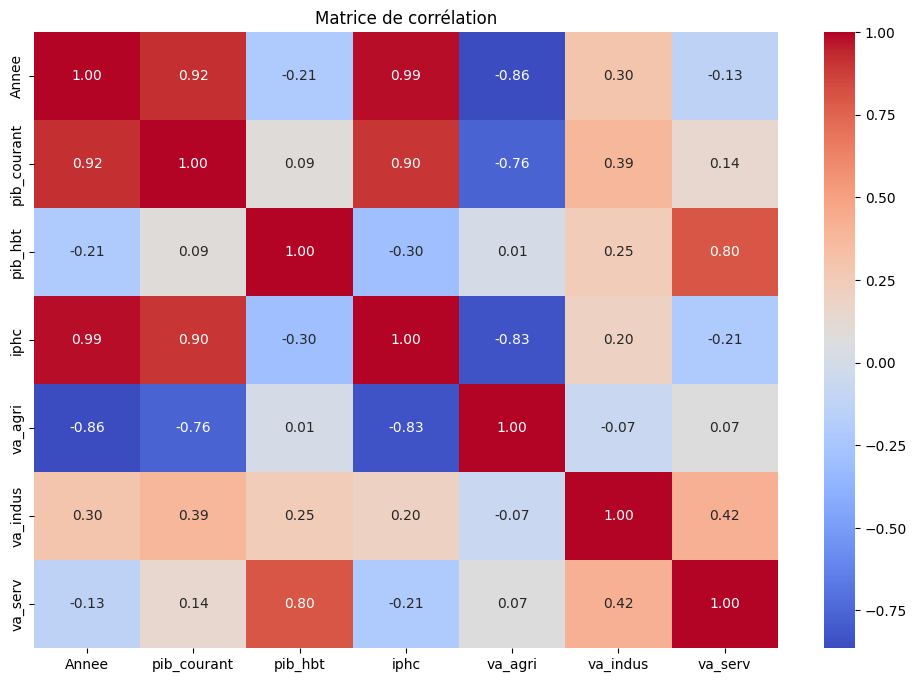

In [10]:
# Corrélation entre les colonnes numériques
correlation_matrix = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matrice de corrélation')
plt.show()

L'analyse de la matrce de correlaton nous emmène à deceler les relations suivantes:
* PIB courant et IPHC : Une forte corrélation positive (r=0.90) indique que l'évolution du PIB courant est étroitement liée à celle de l'indice des prix à la consommation (IPH). Cela suggère que la hausse du PIB est souvent accompagnée par une augmentation des prix.
* PIB courant et VA agricole : Une corrélation négative significative (r=−0.76) montre que lorsque la valeur ajoutée agricole diminue, le PIB courant a tendance à augmenter, ce qui pourrait refléter un déclin relatif du secteur agricole dans l'économie globale.
* VA agricole et IPHC : Une corrélation négative élevée (r=−0.83) indique que des prix plus élevés (IPH) sont associés à une baisse de la contribution agricole, peut-être en raison de contraintes de production
* PIB par habitant et VA services : Une corrélation positive (r=0.80) suggère que la croissance des services est fortement associée à une amélioration du PIB par habitant.
VA industrielle et VA services : Une corrélation positive (r=0.42) reflète une certaine interdépendance entre ces deux secteurs.



**Une etude comparée des valeurs ajoutées**

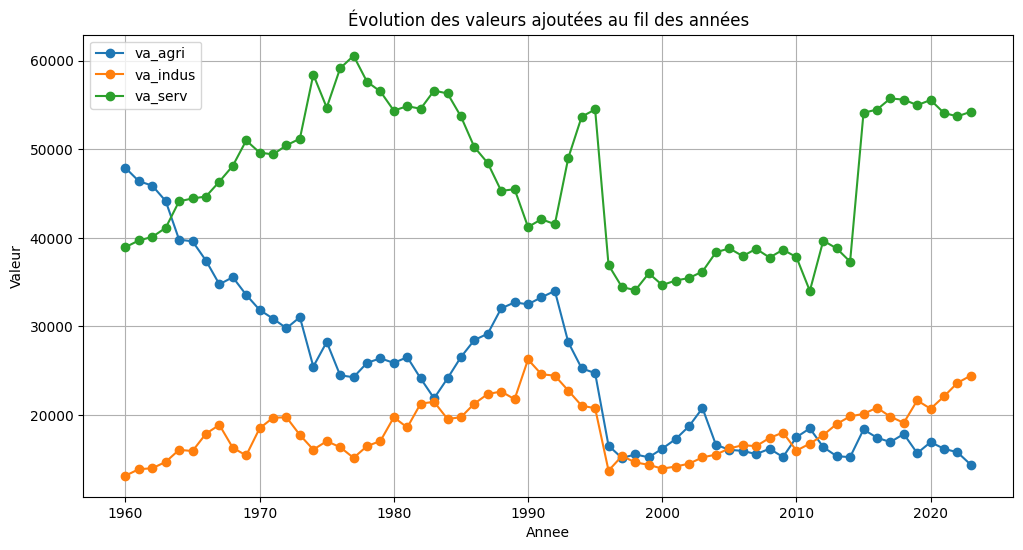

In [11]:

colonnes_selectionnees = ['va_agri', 'va_indus', 'va_serv']

# Tracer le graphique d'évolution pour chaque colonne
plt.figure(figsize=(12, 6))

for colonne in colonnes_selectionnees:
    plt.plot(df['Annee'], df[colonne], marker='o', label=colonne)

plt.title('Évolution des valeurs ajoutées au fil des années')
plt.xlabel('Annee')
plt.ylabel('Valeur')
plt.legend()
plt.grid(True)
plt.show()


Ces trois secteurs montrent une économie en transition, où l’agriculture cède progressivement du terrain au profit des services, tout en soulignant le besoin d’un développement industriel plus robuste pour équilibrer la structure économique.

**REGRESSION POSSIBLE**

* Nous allons examinez l'effet des valeurs ajoutées sectorielles (agriculture, industrie, services) sur le PIB par habitant 

In [3]:

df = pd.read_csv('base_final1_civ.csv')

# Définir les noms des colonnes utilisées pour la régression

col_pib_hbt = 'pib_hbt'       # Variable dépendante
col_va_agri = 'va_agri'       # Valeur ajoutée agriculture
col_va_indus = 'va_indus'     # Valeur ajoutée industrie
col_va_serv = 'va_serv'       # Valeur ajoutée services

X = df[[col_va_agri, col_va_indus, col_va_serv]]
y = df[col_pib_hbt]

# Ajouter une constante pour le modèle
X = sm.add_constant(X)

# Effectuer la régression linéaire
model = sm.OLS(y, X).fit()

# Résumé des résultats
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                pib_hbt   R-squared:                       0.652
Model:                            OLS   Adj. R-squared:                  0.635
Method:                 Least Squares   F-statistic:                     37.53
Date:                Mon, 06 Jan 2025   Prob (F-statistic):           8.75e-14
Time:                        21:12:13   Log-Likelihood:                -438.65
No. Observations:                  64   AIC:                             885.3
Df Residuals:                      60   BIC:                             893.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        426.9112    221.038      1.931      0.0

**Les résultats de la régression montrent que 65,2 % de la variation du PIB par habitant est expliquée par les valeurs ajoutées sectorielles (agriculture, industrie, services). Bien que le modèle soit globalement significatif (p < 0.05), l'effet de l'agriculture et de l'industrie sur le PIB par habitant n'est pas significatif, avec des p-values respectivement de 0.421 et 0.159. En revanche, le secteur des services a un impact positif et significatif (p < 0.001), avec un coefficient de 0.0413, ce qui suggère qu'une augmentation de la valeur ajoutée des services conduit à une hausse du PIB par habitant. La multicolinéarité et l'autocorrélation dans les résidus (Durbin-Watson = 0.625) indiquent la nécessité d'examiner davantage ces problèmes pour améliorer le modèle.**

<span style="color:green">**A Present nous allons analyser l'indice de GINI qui n'avait pas été prises en compte à cause de l'indisponiblité des données sur toute la période de 1960 à 1984 et la période de 2009 à 2023. Dans ce cas extrème, nous n'avons pas eu recours aux méthodes statistique d'imputation**</span> ,
 

**INDICE DE GINI**

Nombre de valeurs manquantes dans l'indice de Gini : 0
Statistiques descriptives de l'indice de Gini :
count    10.000000
mean     40.368000
std       2.524933
min      36.890000
25%      39.057500
50%      39.950000
75%      41.145000
max      45.530000
Name: gini, dtype: float64


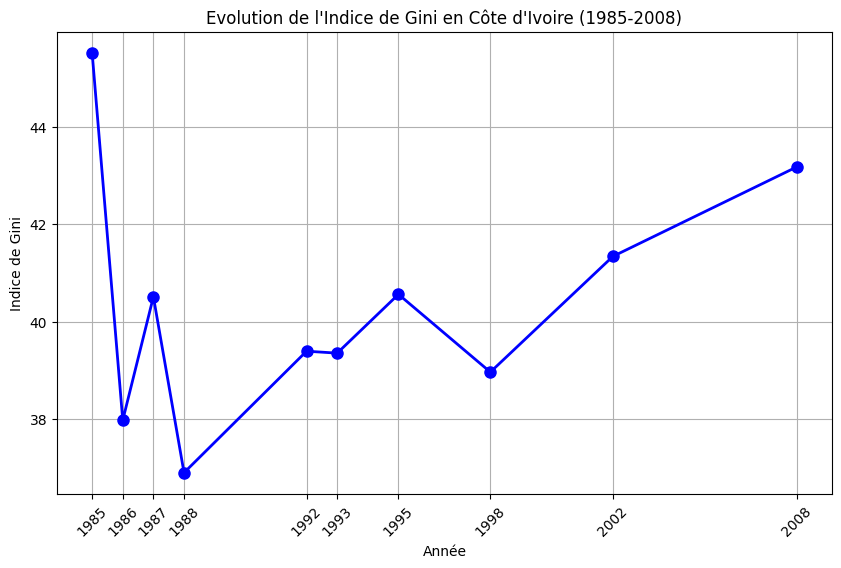

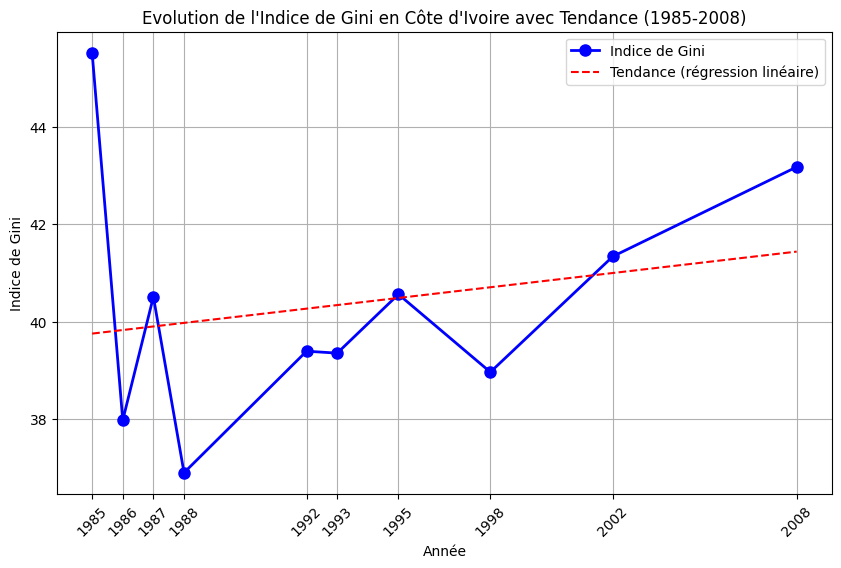

Coefficients de la régression linéaire :
Pente (m) = 0.07332415420928415
Ordonnée à l'origine (b) = -105.79636900078702


In [12]:

# Charger le fichier
file_path = "Scripts/données/gini.csv"  
df = pd.read_csv(file_path)

# Nettoyage de la colonne 'gini' pour supprimer les virgules et convertir en nombre
df['gini'] = df['gini'].replace({',': '.'}, regex=True)  # Supprimer les virgules
df['gini'] = pd.to_numeric(df['gini'], errors='coerce')  # Convertir en numérique, les erreurs seront transformées en NaN

# Vérification des valeurs manquantes pour l'indice de Gini
missing_gini = df['gini'].isnull().sum()
print(f"Nombre de valeurs manquantes dans l'indice de Gini : {missing_gini}")

# Statistiques descriptives pour l'indice de Gini
gini_stats = df['gini'].describe()
print("Statistiques descriptives de l'indice de Gini :")
print(gini_stats)

# Visualiser l'évolution de l'indice de Gini au fil des années
plt.figure(figsize=(10, 6))
plt.plot(df['Année'], df['gini'], marker='o', color='blue', linestyle='-', linewidth=2, markersize=8)
plt.title("Evolution de l'Indice de Gini en Côte d'Ivoire (1985-2008)")
plt.xlabel("Année")
plt.ylabel("Indice de Gini")
plt.grid(True)
plt.xticks(df['Année'], rotation=45)
plt.show()

# analyse de la tendance (régression linéaire ou autre)
X = df['Année'].values.reshape(-1, 1)  
y = df['gini'].values  

model = LinearRegression()
model.fit(X, y)

# Prédire la tendance
y_pred = model.predict(X)

# Tracer la courbe de régression
plt.figure(figsize=(10, 6))
plt.plot(df['Année'], df['gini'], marker='o', color='blue', linestyle='-', linewidth=2, markersize=8, label="Indice de Gini")
plt.plot(df['Année'], y_pred, color='red', linestyle='--', label="Tendance (régression linéaire)")
plt.title("Evolution de l'Indice de Gini en Côte d'Ivoire avec Tendance (1985-2008)")
plt.xlabel("Année")
plt.ylabel("Indice de Gini")
plt.grid(True)
plt.xticks(df['Année'], rotation=45)
plt.legend()
plt.show()

# Coefficients de la régression linéaire
print(f"Coefficients de la régression linéaire :\nPente (m) = {model.coef_[0]}\nOrdonnée à l'origine (b) = {model.intercept_}")


* Le graphique linéaire de l'indice de Gini montre l'évolution des inégalités économiques au fil des années. Il met en évidence des fluctuations importantes dans les niveaux d'inégalité, ainsi que des périodes de stabilité ou de changements significatifs, indiquant soit une tendance à l'augmentation, soit à la réduction des inégalités
* La régression linéaire permet d'identifier la tendance générale de l'indice de Gini. Une pente positive révèle une augmentation des inégalités, tandis qu'une pente négative suggère une diminution. Cette analyse aide à comprendre les facteurs économiques, sociaux et politiques influençant l'évolution des inégalités économiques.

# THEME 2: l'EMPLOI

**Cette fois ci, nous avons scraper les données sur google careers, un ste de google où y'a des publications des offres d'emploi.
l'étude ne sera pas approfondie, il s'agira de faire un nuage de mots pour connaitre les lieux de travail les plus recherchés et les competences les plus recherchées également des differents postes.Nous allons donc mettre en lumière d'abord les postes.**

In [13]:
# Charger le fichier de données
file_path = 'Scripts/offres_emploi_multiple.csv'
df = pd.read_csv(file_path)


In [14]:
print(df.columns)

Index(['Domaine', 'Titre du Poste', 'Nom de l'Entreprise', 'Lieu',
       'Compétences'],
      dtype='object')


**Extraction des postes, lieux et des competences**

In [15]:

postes = df['Titre du Poste'].dropna().str.lower() 
lieux = df['Lieu'].dropna().str.lower()
competences = df['Compétences'].dropna().str.lower()


**Nettoyage**

Python à une lste de mots vide de sens que nous allons supprimer et ensuite enlever certains mots manuellement si possible

In [16]:
# Importer la liste des stopwords en français
stop_words = set(stopwords.words('french'))
# Afficher une partie des stopwords pour vérifier
print(stop_words)


{'eues', 'vos', 'seront', 'il', 'suis', 'eusse', 'eussions', 'étaient', 'm', 'te', 'eûtes', 'aurait', 'fussiez', 'soyez', 'ai', 'ayez', 'ou', 'aurons', 'étantes', 'moi', 'eût', 'les', 'aviez', 'serions', 'd', 'toi', 'lui', 'avons', 'avait', 'vous', 'ton', 'ne', 'une', 'serai', 'ayants', 'ayons', 'ils', 'le', 'on', 'étés', 'fûmes', 'étions', 'fussions', 'auront', 'auras', 'de', 'soient', 'ses', 'eusses', 'pour', 'êtes', 'étante', 'l', 'j', 'fût', 'aient', 'avais', 'étées', 'seriez', 'n', 'pas', 'que', 'leur', 'nous', 'qui', 'nos', 'sera', 'avions', 'ayante', 'aurais', 'été', 'fusse', 'au', 'étants', 'étée', 'aurez', 's', 'des', 'fûtes', 'aie', 'serons', 'ayantes', 'ma', 'sur', 'ait', 'seraient', 'eussent', 'était', 'aies', 'eussiez', 'aux', 'serez', 'ayant', 'eurent', 'eûmes', 'es', 'ce', 'se', 'étant', 'furent', 'mes', 'soyons', 'par', 'ont', 'aura', 'qu', 'en', 'c', 'eut', 'avec', 'est', 'me', 'fussent', 'étiez', 'même', 'auraient', 'la', 'ta', 'avez', 'seras', 'eue', 'dans', 'auriez'

In [17]:
import nltk
nltk.download('punkt_tab')
nltk.data.path.append('D:/ISE/COURS/ALGO_PRO/Projet_Algo_DROH_Romaric/nltk_data')  # Vérifiez 
print(nltk.data.find('tokenizers/punkt'))

C:\Users\DELL\AppData\Roaming\nltk_data\tokenizers\punkt


[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [18]:
# Exemple de nettoyage
def nettoyer_texte(text):
    tokens = word_tokenize(text)  # Devrait maintenant fonctionner
    cleaned_tokens = [word for word in tokens if word.isalpha()]
    return " ".join(cleaned_tokens)



In [19]:
# Appliquer le nettoyage sur les colonnes
postes_cleaned = postes.apply(nettoyer_texte)
lieux_cleaned = lieux.apply(nettoyer_texte)
competences_cleaned = competences.apply(nettoyer_texte)


* Combiner les fichiers

In [20]:
# Créer un DataFrame avec les colonnes nettoyées
df_cleaned = pd.DataFrame({
    'postes': postes_cleaned,
    'lieux': lieux_cleaned,
    'competences': competences_cleaned
})


In [21]:
# Afficher un extrait du DataFrame nettoyé
df_cleaned.head()


,postes,lieux,competences
0,consultant en ia conversationnelle services pr...,austin tx usa montreal qc canada autres autres,baccalauréat en informatique ou expérience pra...
1,doctorat,waterloo on canada montreal qc canada autres a...,inscription à un programme de doctorat en info...
2,stagiaire en recherche doctorat été,waterloo on canada montreal qc canada autres a...,inscription à un programme de doctorat en info...
3,développeur logiciel stagiaire doctorat été,waterloo on canada toronto on canada autres au...,poursuite programme de doctorat axé sur des su...
4,spécialiste de la mise en marché bases de donn...,austin tx usa montreal qc canada autres autres,baccalauréat ou expérience pratique équivalent...


**Après l'affichage, nous allons supprimer certains mots qui se repètent sans nous apporter une information nécessaire** 

In [22]:
mots_a_supprimer = ["autre", "autres", "équivalent","an","en","on","sur","ca","usa","experience","one","district","iii","yeae"]

def supprimer_mots(text, mots_a_supprimer):
    # Séparer le texte en tokens (mots) et supprimer ceux qui sont dans la liste
    mots = text.split()  
    mots_filtrés = [mot for mot in mots if mot.lower() not in mots_a_supprimer]
    return " ".join(mots_filtrés)


In [23]:
# Appliquer la suppression des mots
postes_final = postes_cleaned.apply(lambda x: supprimer_mots(x, mots_a_supprimer))
lieux_final = lieux_cleaned.apply(lambda x: supprimer_mots(x, mots_a_supprimer))
competences_final = competences_cleaned.apply(lambda x: supprimer_mots(x, mots_a_supprimer))


In [24]:
# Afficher un extrait du DataFrame final
df_final = pd.DataFrame({
    'postes': postes_final,
    'lieux': lieux_final,
    'competences': competences_final
})
df_final.head()


,postes,lieux,competences
0,consultant ia conversationnelle services profe...,austin tx montreal qc canada,baccalauréat informatique ou expérience pratiq...
1,doctorat,waterloo canada montreal qc canada,inscription à un programme de doctorat informa...
2,stagiaire recherche doctorat été,waterloo canada montreal qc canada,inscription à un programme de doctorat informa...
3,développeur logiciel stagiaire doctorat été,waterloo canada toronto canada,poursuite programme de doctorat axé des sujets...
4,spécialiste de la mise marché bases de données...,austin tx montreal qc canada,baccalauréat ou expérience pratique équivalent...


* Nuage de mots

In [25]:
# Convertir les listes nettoyées en une chaîne de texte (si ce n'est pas déjà fait)
text_postes = " ".join(postes_final)  # Remplacez "postes_final" par votre liste nettoyée
text_lieux = " ".join(lieux_final)
text_competences = " ".join(competences_final)

# Créer un nuage de mots pour les postes
wordcloud_postes = WordCloud(width=1200, height=600, background_color='white', colormap='viridis', max_words=100).generate(text_postes)

# Créer un nuage de mots pour les lieux
wordcloud_lieux = WordCloud(width=1200, height=600, background_color='white', colormap='viridis', max_words=100).generate(text_lieux)

# Créer un nuage de mots pour les compétences
wordcloud_competences = WordCloud(width=1200, height=600, background_color='white', colormap='viridis', max_words=100).generate(text_competences)

* Nuage de mots pour les postes

(-0.5, 1199.5, 599.5, -0.5)

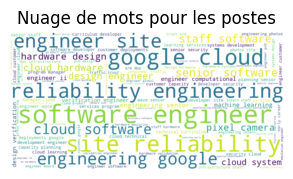

In [26]:
# Afficher les nuages de mots
plt.figure(figsize=(12, 8))

# Afficher celui des postes
plt.subplot(1, 3, 1)
plt.imshow(wordcloud_postes, interpolation='bilinear')
plt.title("Nuage de mots pour les postes")
plt.axis('off')

Il ressort que les postes le plus recheché sont des ingenieurs, des responsables de sites et tout autre meter lié à la technologie

(-0.5, 1199.5, 599.5, -0.5)

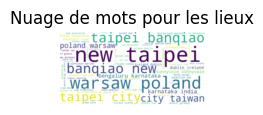

In [27]:
# Afficher celui des lieux
plt.subplot(1, 3, 2)
plt.imshow(wordcloud_lieux, interpolation='bilinear')
plt.title("Nuage de mots pour les lieux")
plt.axis('off')

(-0.5, 1199.5, 599.5, -0.5)

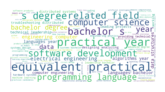

In [28]:
# Afficher celui des compétences
plt.subplot(1, 3, 3)
plt.imshow(wordcloud_competences, interpolation='bilinear')

plt.axis('off')


Pour les competences il faut avoir au minimum le bachelor ou d'autres diplôme équivalent